In [1]:
import pandas as pd
import torch#深度学习的pytoch平台
import torch.nn as nn
import numpy as np
import random
import time#可以用来简单地记录时间
import matplotlib.pyplot as plt#画图
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
import os

from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
from models.dual_adaptation_gate import DAG_Tabular, TabTransformer, mm_tab
from models.train_and_test_step import train_model, test_model, evaluate_model, plot_result

In [3]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import torchvision
import torchvision.transforms as transforms

# 加载数据

In [4]:
file_path = '../datasets/mimic/'
df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')
df_val = pd.read_csv(file_path + 'val.csv')

# Check device

In [5]:
# Check device 
# Get the GPU device name if available.
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
torch.cuda.empty_cache()
    
# Set the seed value all over the place to make this reproducible.
seed_val = 43

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
os.environ['PYTHONHASHSEED'] = str(seed_val)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

There are %d GPU(s) available. 1
We will use the GPU: NVIDIA GeForce GTX 1080 Ti


# Define hybrid parameters

In [6]:
batch_size = 64
epochs = 20
learning_rate = 1e-3 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = int(len(df_train) / batch_size / 1 * epochs)
num_workers = 0

# Load data

In [7]:
cat_cols = ["admission_type", 'gender', 'ethnicity', # 'marital_status', "insurance", "language",
            "electivesurgery", "vent",
#             'vasopressor', 'milrinone', 'furosemide',  # 升压药、强心剂、利尿剂
            'activity','fall_risk',
#             'braden_nutrition', 'braden_mobility', 'braden_activity',
#             'lll_lung_sounds','lul_lung_sounds','rll_lung_sounds', 'rul_lung_sounds'
           ]

numerical_cols = ["pre_icu_los_day",'age','weight', #'spo2_fio2_ratio',
                  'bmi', 'creatinine_max', 'bilirubin_max',
                  'platelet_min', 'bun_max', 'wbc_max', 'glucose_max',
                  'hematocrit_max', 'potassium_max', 'sodium_max', 'bicarbonate_min', 'bicarbonate_max',
                  'pao2fio2ratio_vent', 'albumin_min', 'alt_max', 'ast_max', 'alp_max', 'pt_max',
                  'ptt_max', 'inr_min', 'hemoglobin_min', 'chloride_min', 'pao2_min', 'paco2_max', 'lactate_max',
                  'baseexcess_min', 'fio2_max', 'troponin_max', 'lymphocytes_max', 'lymphocytes_min', 'neutrophils_min',
                  'magnesium_max','aniongap_max', 'gcs_min',
                  'urineoutput', 'spo2_min', 'heart_rate_mean', 'mbp_mean',
                  'sbp_mean', 'resp_rate_mean', 'temperature_mean',
                  'cci_score',
                ]

tabular_cols = cat_cols + numerical_cols

In [8]:
X_train = df_train.loc[:, tabular_cols]
X_val = df_val.loc[:, tabular_cols]
X_test = df_test.loc[:, tabular_cols]

y_train = df_train['death_hosp']
y_val = df_val['death_hosp']
y_test = df_test['death_hosp']

# Tabular to Image

E:\Program_Files\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


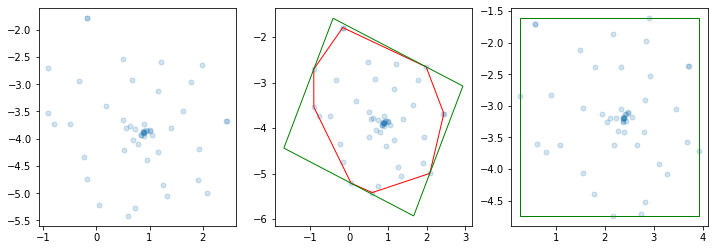

In [9]:
# Normalize data using LogScaler
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_val_norm = ln.transform(X_val)
X_test_norm = ln.transform(X_test)

# Create t-SNE object
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1,
    random_state=seed_val
)

# Initialize image transformer
pixel_size = ( 8, 8)
it = ImageTransformer(
    feature_extractor=reducer, 
#     feature_extractor='pca',
    pixels=pixel_size)

it.fit(X_train, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_val_img = it.transform(X_val_norm)
X_test_img = it.transform(X_test_norm)

In [10]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [11]:
train_img = torch.stack([preprocess(img) for img in X_train_img]).float()
val_img = torch.stack([preprocess(img) for img in X_val_img]).float()
test_img = torch.stack([preprocess(img) for img in X_test_img]).float()

# Make dataset

In [12]:
def loadData(prep_df, batch_size, num_workers, sampler):
    
    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

train_cat = torch.tensor(np.array(df_train.loc[:, cat_cols],dtype=np.int32))
train_num = torch.tensor(np.array(df_train.loc[:, numerical_cols],dtype=np.float32))
train_y = torch.tensor(df_train.death_hosp.astype(int).tolist())

val_cat = torch.tensor(np.array(df_val.loc[:, cat_cols],dtype=np.int32))
val_num = torch.tensor(np.array(df_val.loc[:, numerical_cols],dtype=np.float32))
val_y = torch.tensor(df_val.death_hosp.astype(int).tolist())

test_cat = torch.tensor(np.array(df_test.loc[:, cat_cols],dtype=np.int32))
test_num = torch.tensor(np.array(df_test.loc[:, numerical_cols],dtype=np.float32))
test_y = torch.tensor(df_test.death_hosp.astype(int).tolist())

In [13]:
# wrap tensors
train_data = TensorDataset(train_cat, train_num, train_img, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_cat, val_num, val_img, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_cat, test_num, test_img, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)

In [14]:
print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

Number of data in the train set 141
Number of data in the validation set 18
Number of data in the test set 18


# Load model

In [15]:
model = mm_tab(categories = (2,2,2,2,2,2,2),      # tuple containing the number of unique values within each category
                        num_continuous = 45,                # number of continuous values
                        dim = 16,                           # dimension, paper set at 32
                        dim_out = 1,                        # binary prediction, but could be anything
                        depth = 1,                          # depth, paper recommended 6
                        heads = 1,                          # heads, paper recommends 8
                        attn_dropout = 0.1,                 # post-attention dropout
                        ff_dropout = 0.1,                   # feed forward dropout
                        mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
                      )
model.to(device) # Model to GPU.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

E:\Program_Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
E:\Program_Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def training_model(model, traindata, bceloss, optimizer, epochs=12):
    # for each epoch perform training and evaluation
    for epoch in range(epochs):
        #train model
        train_loss, _ = train_model(model, traindata, bceloss, optimizer)
        
def evaluate_models_with_auc(model, test_data, df_data):
    preds = test_model(model, test_data)
    
    fpr, tpr, thresholds = roc_curve(df_data['death_hosp'], preds[0])
    auc_score = auc(fpr, tpr)
    return auc_score

In [17]:
bceloss  = nn.BCELoss()

In [18]:
# set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train_model(model, traindata, bceloss, optimizer)
    
    #evaluate model
    valid_loss, _ = evaluate_model(model, valdata, bceloss)
    
    print('Evaluation done for epoch {}'.format(epoch + 1))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
Training...
  Batch    50  of    141. loss 0.2786973714828491
  Batch   100  of    141. loss 0.311071515083313

Evaluating...
Evaluation done for epoch 1

Training Loss: 0.378
Validation Loss: 0.339

 Epoch 2 / 20
Training...
  Batch    50  of    141. loss 0.5248568058013916
  Batch   100  of    141. loss 0.21264711022377014

Evaluating...
Evaluation done for epoch 2

Training Loss: 0.331
Validation Loss: 0.334

 Epoch 3 / 20
Training...
  Batch    50  of    141. loss 0.20936666429042816
  Batch   100  of    141. loss 0.28823116421699524

Evaluating...
Evaluation done for epoch 3

Training Loss: 0.321
Validation Loss: 0.344

 Epoch 4 / 20
Training...
  Batch    50  of    141. loss 0.24427849054336548
  Batch   100  of    141. loss 0.42063507437705994

Evaluating...
Evaluation done for epoch 4

Training Loss: 0.326
Validation Loss: 0.355

 Epoch 5 / 20
Training...
  Batch    50  of    141. loss 0.4099435806274414
  Batch   100  of    141. loss 0.21299132704734802

Evaluat

In [19]:
preds = test_model(model, testdata)


Test Set...
Total batches: 18
Batch 18
Prediction complete.


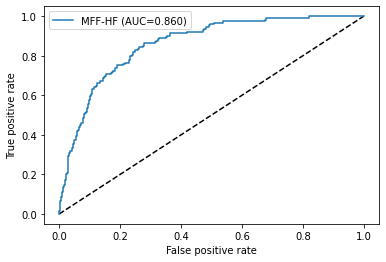

In [20]:
plot_result(df_test['death_hosp'], preds[0])

# 外部验证

In [21]:
df_external = pd.read_csv(file_path + 'external.csv')
df_temporal = pd.read_csv(file_path + 'mimiciv_temporal_data_preprocess.csv')

In [22]:
X_external = df_external.loc[:, tabular_cols]
X_temporal = df_temporal.loc[:, tabular_cols]

y_external = df_external['death_hosp']
y_temporal = df_temporal['death_hosp']

In [23]:
X_external_norm = ln.fit_transform(X_external)
X_temporal_norm = ln.transform(X_temporal)

X_external_img = it.transform(X_external_norm)
X_temporal_img = it.transform(X_temporal_norm)

In [24]:
external_img = torch.stack([preprocess(img) for img in X_external_img]).float()
temporal_img = torch.stack([preprocess(img) for img in X_temporal_img]).float()

In [25]:
external_cat = torch.tensor(np.array(df_external.loc[:, cat_cols],dtype=np.int32))
external_num = torch.tensor(np.array(df_external.loc[:, numerical_cols],dtype=np.float32))
external_y = torch.tensor(df_external.death_hosp.astype(int).tolist())


temporal_cat = torch.tensor(np.array(df_temporal.loc[:, cat_cols],dtype=np.int32))
temporal_num = torch.tensor(np.array(df_temporal.loc[:, numerical_cols],dtype=np.float32))
temporal_y = torch.tensor(df_temporal.death_hosp.astype(int).tolist())

# wrap tensors
external_data = TensorDataset(external_cat, external_num, external_img, external_y)
# sampler for sampling the data during training
external_sampler = SequentialSampler(external_data)
# Val Data Loader
externaldata = loadData(external_data, batch_size, num_workers, external_sampler)

# wrap tensors
temporal_data = TensorDataset(temporal_cat, temporal_num, temporal_img, temporal_y)
# sampler for sampling the data during training
temporal_sampler = SequentialSampler(temporal_data)
# Val Data Loader
temporaldata = loadData(temporal_data, batch_size, num_workers, temporal_sampler)

print('Number of data in the external set', len(externaldata))
print('Number of data in the temporal set', len(temporaldata))

Number of data in the external set 80
Number of data in the temporal set 30


In [26]:
temporalpreds = test_model(model, temporaldata)


Test Set...
Total batches: 30
Batch 30
Prediction complete.


In [27]:
temporal_results = {'preds':temporalpreds[0].reshape(-1),
                   'death_hosp':np.array(df_temporal['death_hosp'])}

df_temporal_results = pd.DataFrame(temporal_results).dropna()

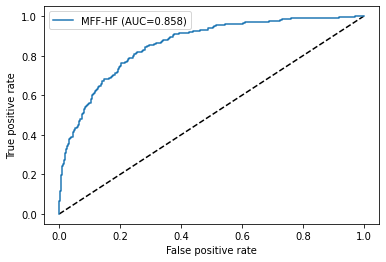

In [28]:
plot_result(df_temporal_results['death_hosp'], df_temporal_results['preds'])


Test Set...
Total batches: 80
Batch 80
Prediction complete.


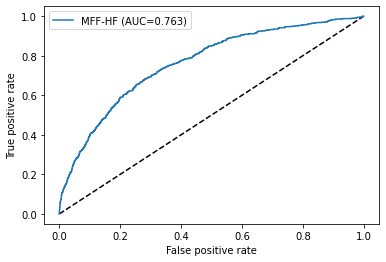

In [29]:
externalpreds = test_model(model, externaldata)
plot_result(df_external['death_hosp'], externalpreds[0])

# Eval the model

# 临床评分

In [30]:
df_mimiciii_all = pd.read_csv(file_path + 'two_days_data_preprocess.csv')
df_train_copd = df_mimiciii_all[df_mimiciii_all.hadm_id.isin(df_train.hadm_id)]
df_test_copd = df_mimiciii_all[df_mimiciii_all.hadm_id.isin(df_test.hadm_id)]
df_val_copd = df_mimiciii_all[df_mimiciii_all.hadm_id.isin(df_val.hadm_id)]

# SOFA

In [31]:
from numpy import interp

def cal_nomodel_confidence_interval(x_test, y_test):
    data_plot = []
    auc_list = []  
    for i in range(100):
        # 随机采样训练集合
        x_external_val_test = x_test.sample(frac = 0.9, random_state = i)
        y_external_val_test = y_test.loc[x_external_val_test.index, :]

        mean_tpr_xgb = 0.0
        mean_fpr_xgb = np.linspace(0, 1, 100)
        
        x_external_val_test = x_external_val_test/22

        probas_ = x_external_val_test.loc[:,:]
        fpr, tpr, thresholds = roc_curve(y_external_val_test, probas_)
        mean_tpr_xgb += interp(mean_fpr_xgb, fpr, tpr)			#对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数
        mean_tpr_xgb[0] = 0.0

        # xgboost 平均AUC
        mean_tpr_xgb[-1] = 1.0 #坐标最后一个点为（1,1）
        mean_auc_xgb = auc(mean_fpr_xgb, mean_tpr_xgb)#计算平均AUC值

        data_plot.append(mean_tpr_xgb)
        auc_list.append(mean_auc_xgb)

    data_plot = np.array(data_plot)
    sorts = sorted(auc_list)
    data_plot = data_plot[np.argsort(auc_list)]

    x =95
    k = len(sorts)
    gap = (k - (x/100)*k)/2
    l_limit_idx = int(gap)
    u_limit_idx = int(k-gap)
    
    return sorts, l_limit_idx, u_limit_idx

def plot_sofa(X_sofa_test, y_test):
    X_sofa2 = X_sofa_test/22
    mean_tpr_xgb_sofa = 0.0
    mean_fpr_xgb_sofa = np.linspace(0, 1, 100)

    probas_ = X_sofa2
    #通过roc_curve()函数，求出fpr和tpr，以及阈值
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    mean_tpr_xgb_sofa += interp(mean_fpr_xgb_sofa, fpr, tpr) #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数
    mean_tpr_xgb_sofa[0] = 0.0    #初始处为0

    mean_tpr_xgb_sofa[-1] = 1.0 #坐标最后一个点为（1,1）
    mean_auc_xgb_sofa = auc(mean_fpr_xgb_sofa, mean_tpr_xgb_sofa)#计算平均AUC值

    sorts, l_limit_idx, u_limit_idx = cal_nomodel_confidence_interval(X_sofa_test, y_test)

    #画平均ROC曲线
    plt.plot(mean_fpr_xgb_sofa, mean_tpr_xgb_sofa, label='SOFA (AUC=%0.3f)' % mean_auc_xgb_sofa, lw=2)

    #画对角线
    # plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")

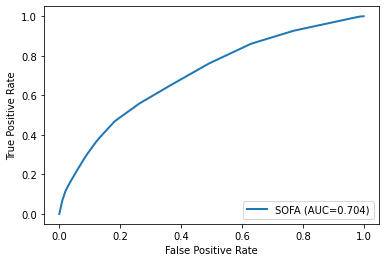

In [32]:
plot_sofa(df_train_copd.loc[:, ['sofa']], df_train_copd.loc[:, ['death_hosp']])

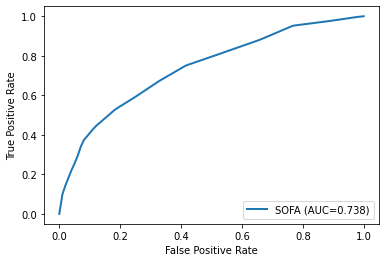

In [33]:
plot_sofa(df_temporal.loc[:, ['sofa']], df_temporal.loc[:, ['death_hosp']])

# GWTG-HF

In [34]:
def cal_GWTG_hf(X_data):
    bp = X_data.sbp_mean
    bun = X_data.bun_max
    sodium = X_data.sodium_max
    age = X_data.age
    heartrate = X_data.heart_rate_mean
    black = X_data.ethnicity
    copd = X_data.chronic_obstructive_pulmonary_disease
    
#     print('sbp:',bp,'\n','bun:',bun,'\n','sodium:',sodium,'\n','age:', age, '\n','heart rate:', heartrate,'\n','black',black,'\n','copd:',copd)
    
    point=0
    
    # calculate bp points 
    if 50<=bp and bp<=59:
        point = point + 28
    elif 60<=bp and bp<=69:
        point = point + 26
    elif 70<=bp and bp<=79:
        point = point + 24
    elif 80<=bp and bp<=89:
        point = point + 23
    elif 90<=bp and bp<=99:
        point = point + 21
    elif 100<=bp and bp<=109:
        point = point + 19
    elif 110<=bp and bp<=119:
        point = point + 17
    elif 120<=bp and bp<=129:
        point = point + 15
    elif 130<=bp and bp<=139:
        point = point + 13
    elif 140<=bp and bp<=149:
        point = point + 11
    elif 150<=bp and bp<=159:
        point = point + 9
    elif 160<=bp and bp<=169:
        point = point + 8
    elif 170<=bp and bp<=179:
        point = point + 6
    elif 180<=bp and bp<=189:
        point = point + 4
    elif 190<=bp and bp<=199:
        point = point + 2
    elif 200<=bp:
        point = point + 0
        
    # calculate bun points 
    if bun<=9:
        point = point + 0
    elif 10<=bun and bun<=19:
        point = point + 2
    elif 20<=bun and bun<=29:
        point = point + 4
    elif 30<=bun and bun<=39:
        point = point + 6
    elif 40<=bun and bun<=49:
        point = point + 8
    elif 50<=bun and bun<=59:
        point = point + 9
    elif 60<=bun and bun<=69:
        point = point + 11
    elif 70<=bun and bun<=79:
        point = point + 13
    elif 80<=bun and bun<=89:
        point = point + 15
    elif 90<=bun and bun<=99:
        point = point + 17
    elif 100<=bun and bun<=109:
        point = point + 19
    elif 110<=bun and bun<=119:
        point = point + 21
    elif 120<=bun and bun<=129:
        point = point + 23
    elif 130<=bun and bun<=139:
        point = point + 25
    elif 140<=bun and bun<=149:
        point = point + 27
    elif 150<=bun :
        point = point + 28
        
    # calculate sodium points 
    if sodium<=130:
        point = point + 4
    elif sodium==131 or sodium==132 or sodium==133:
        point = point + 3
    elif sodium==134 or sodium==135 or sodium==136:
        point = point + 2
    elif sodium==137 or sodium==138:
        point = point + 1
    if sodium>=139:
        point = point + 0
        
    # calculate age points 
    if age<=19:
        point = point + 0
    elif 20<=age and age<=29:
        point = point + 3
    elif 30<=age and age<=39:
        point = point + 6
    elif 40<=age and age<=49:
        point = point + 8
    elif 50<=age and age<=59:
        point = point + 11
    elif 60<=age and age<=69:
        point = point + 14
    elif 70<=age and age<=79:
        point = point + 17
    elif 80<=age and age<=89:
        point = point + 19
    elif 90<=age and age<=99:
        point = point + 22
    elif 100<=age and age<=109:
        point = point + 25
    elif 110<=age:
        point = point + 28
        
    # calculate heart rate points 
    if heartrate<=79:
        point = point + 0
    elif 80<=heartrate and heartrate<=84:
        point = point + 1
    elif 85<=heartrate and heartrate<=89:
        point = point + 3
    elif 90<=heartrate and heartrate<=94:
        point = point + 4
    elif 95<=heartrate and heartrate<=99:
        point = point + 5
    elif 100<=heartrate and heartrate<=104:
        point = point + 6
    elif 105<=heartrate:
        point = point + 8
        
    # calculate black man points 
    if black==1:
        point = point + 0
    else:
        point = point + 3
        
    # calculate COPD points 
    if copd==1:
        point = point + 2
    else:
        point = point + 0
    
    # calculate probability of death according to point    
    prop_of_death = 0
    if 0<=point and point<=33:
        prop_of_death = 0.01
    elif 34<=point and point<=50:
        prop_of_death = 0.03
    elif 51<=point and point<=57:
        prop_of_death = 0.13
    elif 58<=point and point<=61:
        prop_of_death = 0.17
    elif 62<=point and point<=65:
        prop_of_death = 0.25
    elif 66<=point and point<=70:
        prop_of_death = 0.35
    elif 75<=point and point<=78:
        prop_of_death = 0.45
    elif 79<=point:
        prop_of_death = 0.51
    
    return point

cal_GWTG_hf(df_mimiciii_all.loc[0, :])

56

In [35]:
data_gwtg = df_mimiciii_all.loc[:, ['sbp_mean' ,'bun_max','sodium_max','age','heart_rate_mean',
                          'ethnicity','chronic_obstructive_pulmonary_disease', 'death_hosp']].dropna().reset_index(drop=True)
# data_gwtg['ethnicity'] = data_gwtg['ethnicity'].map({'asian': 0, 'black': 1, 'hispanic': 0,  "other": 0, "white":  0}).astype(int)
data_gwtg

,sbp_mean,bun_max,sodium_max,age,heart_rate_mean,ethnicity,chronic_obstructive_pulmonary_disease,death_hosp
0,103.0,53.0,153.0,76.0,111.8,0,0,0
1,159.4,17.0,140.0,41.0,92.5,0,0,1
2,105.8,102.0,140.0,87.0,67.8,0,0,0
3,98.0,33.0,143.0,72.0,62.5,0,0,0
4,113.7,46.0,129.0,92.4,81.0,0,0,0
...,...,...,...,...,...,...,...,...
12851,112.9,28.0,141.0,76.0,79.3,0,0,0
12852,99.1,16.0,139.0,53.0,99.0,0,0,0
12853,119.7,70.0,134.0,82.0,96.0,0,0,0
12854,123.8,19.0,140.0,66.0,62.9,0,0,0


In [36]:
data_gwtg_temporal = df_temporal.loc[:, ['sbp_mean' ,'bun_max','sodium_max','age','heart_rate_mean',
                          'ethnicity','chronic_obstructive_pulmonary_disease', 'death_hosp']].dropna().reset_index(drop=True)
# data_gwtg['ethnicity'] = data_gwtg['ethnicity'].map({'asian': 0, 'black': 1, 'hispanic': 0,  "other": 0, "white":  0}).astype(int)
data_gwtg_temporal

,sbp_mean,bun_max,sodium_max,age,heart_rate_mean,ethnicity,chronic_obstructive_pulmonary_disease,death_hosp
0,117.6,14.0,132.0,70,75.0,0,0,0
1,107.0,36.0,146.0,91,92.2,0,0,0
2,105.5,33.0,147.0,81,66.9,0,0,0
3,112.0,28.0,135.0,68,81.1,0,1,0
4,94.7,18.0,147.0,42,101.4,0,0,1
...,...,...,...,...,...,...,...,...
1891,139.7,17.0,144.0,88,86.8,0,0,0
1892,101.8,21.0,129.0,81,118.2,1,0,0
1893,145.3,26.0,145.0,91,63.0,0,0,1
1894,107.0,34.0,143.0,56,68.9,0,0,0


In [37]:
# 循环整个dataframe
from tqdm import tqdm
tqdm.pandas(desc='pandas bar') 
df_gwtg_X = pd.DataFrame({})
df_gwtg_X["prop_of_death"] = data_gwtg.progress_apply(cal_GWTG_hf, axis=1)

df_gwtg_X_temporal = pd.DataFrame({})
df_gwtg_X_temporal["prop_of_death"] = data_gwtg_temporal.progress_apply(cal_GWTG_hf, axis=1)

pandas bar: 100%|███████████████████████████████████████████████████████████████| 1896/1896 [00:00<00:00, 13550.62it/s]


In [38]:
def plot_gwtg_hf(df_gwtg, data_gwtg_origin):
    # GWTG 评分
    X_gwtg = df_gwtg.loc[:, ["prop_of_death"]]
    y_gwtg = data_gwtg_origin.loc[:, ["death_hosp"]]

    mean_tpr_xgb_gwtg = 0.0
    mean_fpr_xgb_gwtg = np.linspace(0, 1, 100)

    probas_ = X_gwtg.loc[:,:]
    #通过roc_curve()函数，求出fpr和tpr，以及阈值
    fpr, tpr, thresholds = roc_curve(y_gwtg.loc[:, :], probas_)
    mean_tpr_xgb_gwtg += interp(mean_fpr_xgb_gwtg, fpr, tpr) #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数
    mean_tpr_xgb_gwtg[0] = 0.0 #初始处为0
    roc_auc = auc(fpr, tpr)

    # SOFA平均AUC
    mean_tpr_xgb_gwtg /= 1 #在mean_fpr100个点，每个点处插值插值多次取平均
    mean_tpr_xgb_gwtg[-1] = 1.0 #坐标最后一个点为（1,1）
    mean_auc_xgb_gwtg = auc(mean_fpr_xgb_gwtg, mean_tpr_xgb_gwtg)#计算平均AUC值

    sorts, l_limit_idx, u_limit_idx = cal_nomodel_confidence_interval(X_gwtg, y_gwtg)

    #画平均ROC曲线
    plt.plot(mean_fpr_xgb_gwtg, mean_tpr_xgb_gwtg, label='GWTG-HF (AUC=%0.3f)' % mean_auc_xgb_gwtg, lw=2)

    #画对角线
#     plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    # plt.plot(mean_fpr_xgb_gwtg, mean_tpr_xgb_gwtg, label='GWTG-HF Mean ROC (area = %0.3f)' % mean_auc_xgb_gwtg, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
#     plt.show()

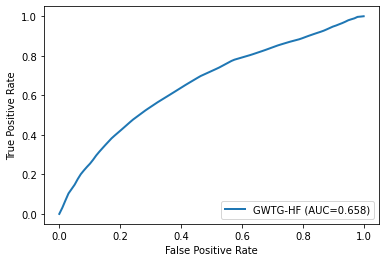

In [39]:
plot_gwtg_hf(df_gwtg_X, data_gwtg)

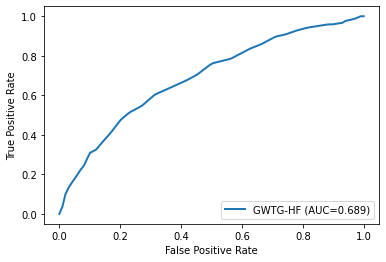

In [40]:
plot_gwtg_hf( df_gwtg_X_temporal, data_gwtg_temporal)

# 合并图像

In [41]:
from matplotlib import rcParams

config = {
    "font.family":'Times New Roman',
    "font.size": 13,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
    "font.weight": 'bold',
}
rcParams.update(config)

plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 用来正常显示中文标签

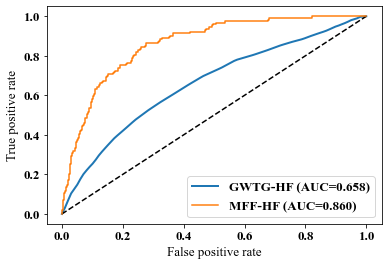

In [42]:
# plot_sofa(df_train_copd.loc[:, ['sofa']], df_train_copd.loc[:, ['death_hosp']])
plot_gwtg_hf(df_gwtg_X, data_gwtg)
plot_result(df_test['death_hosp'], preds[0])

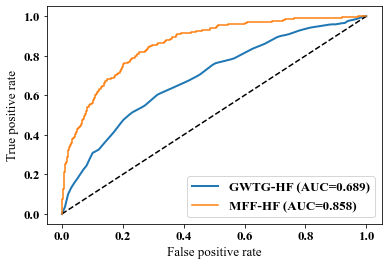

In [43]:
# plot_sofa(df_temporal.loc[:, ['sofa']], df_temporal.loc[:, ['death_hosp']])
plot_gwtg_hf( df_gwtg_X_temporal, data_gwtg_temporal)
plot_result(df_temporal_results['death_hosp'], df_temporal_results['preds'])